<a href="https://colab.research.google.com/github/SachinBiswas7/-Bangla-Text-Violence-Nature-and-Target-Classification/blob/main/task_2_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

In [2]:
# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = pd.read_csv("train_modified.csv")
dev_df = pd.read_csv("dev_modified.csv")
test_df = pd.read_csv("test_modified.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
# Step 1: Apply Random Oversampling to Balance the Datasets
def oversample_dataset(df):
    # Drop rows where 'text' or 'label' is NaN
    df = df.dropna(subset=['text', 'label'])

    # Ensure labels are integers
    df["label"] = df["label"].astype(int)

    ros = RandomOverSampler(random_state=42)
    texts, labels = df["text"].values.reshape(-1, 1), df["label"].values

    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    balanced_df = pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})
    return balanced_df

# Apply oversampling after fixing NaN issues
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)


<ipython-input-3-32a89c0bd22a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["label"].astype(int)


In [4]:
# **Step 2: Preprocessing Function**
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

In [5]:
# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# **Step 4: Capsule Network Layer**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

In [7]:
# **Step 5: Define CAPTAIN Model**
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

In [8]:
# **Step 6: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [5]:
# **Step 7: Training Loop**
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

Epoch 1 Loss: 124.9582, Accuracy: 0.5440


Epoch 2 Loss: 72.4856, Accuracy: 0.7924


Epoch 3 Loss: 47.1298, Accuracy: 0.8764


Epoch 4 Loss: 22.9368, Accuracy: 0.9486


Epoch 5 Loss: 14.5632, Accuracy: 0.9743


Epoch 6 Loss: 7.4541, Accuracy: 0.9894


Epoch 7 Loss: 5.3526, Accuracy: 0.9930


Epoch 8 Loss: 3.6703, Accuracy: 0.9959


Epoch 9 Loss: 3.4244, Accuracy: 0.9966


Epoch 10 Loss: 2.6899, Accuracy: 0.9974


Epoch 11 Loss: 3.0808, Accuracy: 0.9966


Epoch 12 Loss: 2.3053, Accuracy: 0.9981


Epoch 13 Loss: 1.7918, Accuracy: 0.9978


Epoch 14 Loss: 1.1782, Accuracy: 0.9990


Epoch 15 Loss: 1.1573, Accuracy: 0.9993


Epoch 16 Loss: 0.9474, Accuracy: 0.9993


Epoch 17 Loss: 1.2905, Accuracy: 0.9981


Epoch 18 Loss: 1.1178, Accuracy: 0.9995


Epoch 19 Loss: 0.9864, Accuracy: 0.9990


Epoch 20 Loss: 0.7317, Accuracy: 0.9998


In [6]:


# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7273    0.8276    0.7742      1096
           1     0.7805    0.6651    0.7182      1096
           2     0.8229    0.8312    0.8271      1096

    accuracy                         0.7746      3288
   macro avg     0.7769    0.7746    0.7732      3288
weighted avg     0.7769    0.7746    0.7732      3288



In [7]:
#save the model
torch.save(model.state_dict(), 'model.pth')

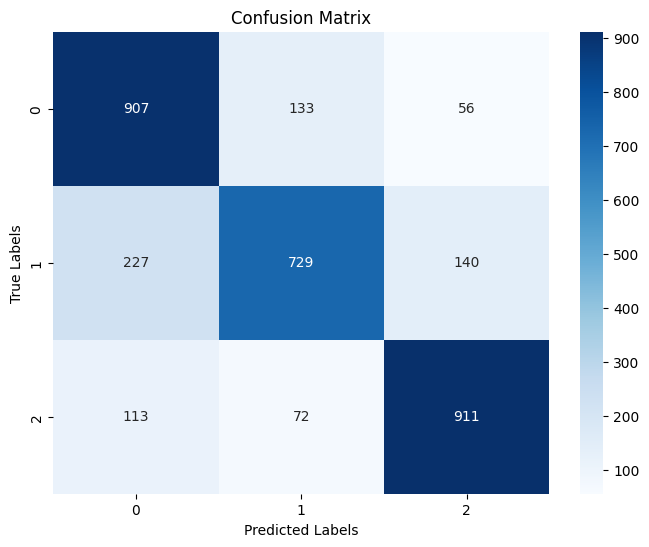

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


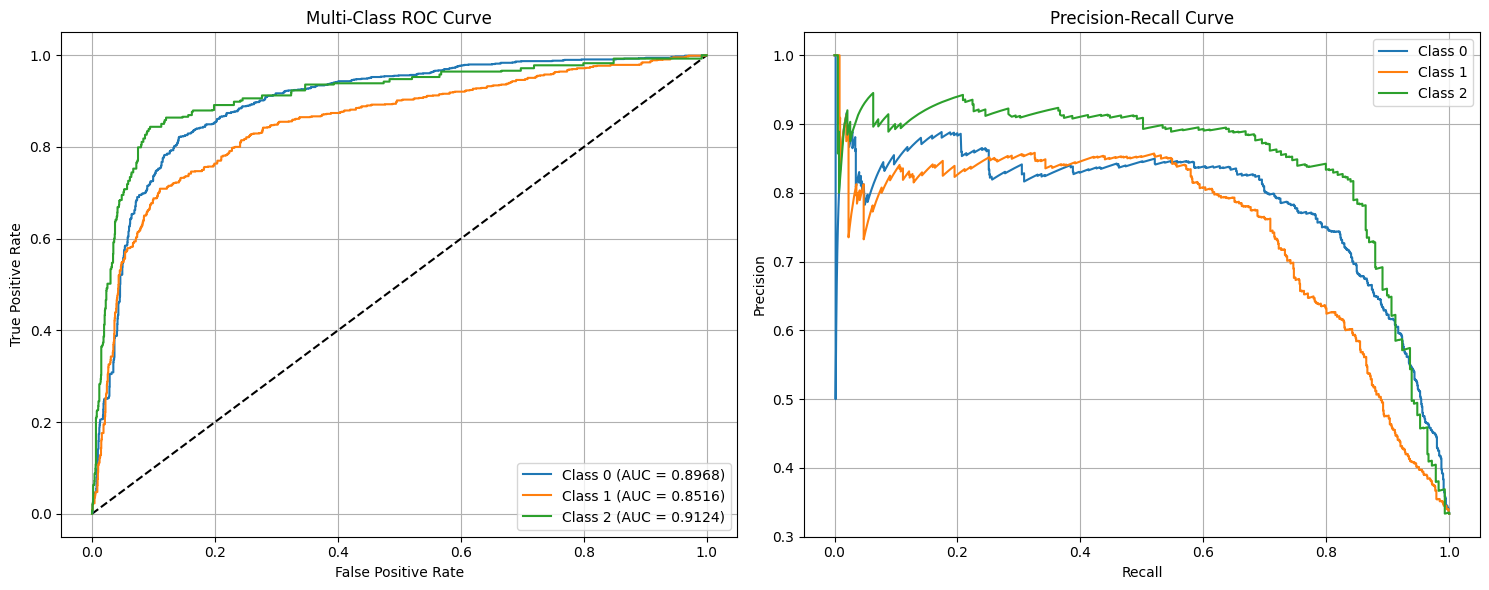

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# *Step 1: Convert True Labels to One-Hot Encoding (Required for Multi-Class)*
num_classes = len(set(true_labels))  # Number of classes
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# *Step 2: Get Softmax Probabilities for ROC & PR Curves*
model.eval()
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.exp(outputs).cpu().numpy()  # Convert log-softmax to probabilities
        all_probs.extend(probs)

all_probs = np.array(all_probs)

# *Step 3 & 4: Plot ROC and Precision-Recall Curves Side by Side*
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create 1 row, 2 columns

# ---- Plot ROC Curve ----
axes[0].set_title("Multi-Class ROC Curve")
axes[0].plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].grid()

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

axes[0].legend()

# ---- Plot Precision-Recall Curve ----
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].grid()

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], all_probs[:, i])
    axes[1].plot(recall, precision, label=f"Class {i}")

axes[1].legend()

plt.tight_layout()  # Adjust layout for better visualization
plt.show()

# banglabert with stopwords

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = pd.read_csv("train_modified.csv")
dev_df = pd.read_csv("dev_modified.csv")
test_df = pd.read_csv("test_modified.csv")

# Step 1: Apply Random Oversampling to Balance the Datasets
def oversample_dataset(df):
    # Drop rows where 'text' or 'label' is NaN
    df = df.dropna(subset=['text', 'label'])

    # Ensure labels are integers
    df["label"] = df["label"].astype(int)

    ros = RandomOverSampler(random_state=42)
    texts, labels = df["text"].values.reshape(-1, 1), df["label"].values

    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    balanced_df = pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})
    return balanced_df

# Apply oversampling after fixing NaN issues
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)



# **Step 2: Preprocessing Function**
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Step 4: Capsule Network Layer**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# **Step 5: Define CAPTAIN Model**
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.8)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# **Step 6: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# **Step 7: Training Loop**
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


#banglabert without stopwords

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = pd.read_csv("train_modified.csv")
dev_df = pd.read_csv("dev_modified.csv")
test_df = pd.read_csv("test_modified.csv")

# Load Stopwords
def load_stopwords(file_path="stopwords_bangla.csv"):
    stopwords_df = pd.read_csv(file_path)
    stopwords_list = set(stopwords_df["words"].dropna().tolist())  # Ensure no NaN values
    return stopwords_list

STOPWORDS = load_stopwords()  # Load stopwords once

# Step 1: Apply Random Oversampling to Balance the Datasets
def oversample_dataset(df):
    # Drop rows where 'text' or 'label' is NaN
    df = df.dropna(subset=['text', 'label'])

    # Ensure labels are integers
    df["label"] = df["label"].astype(int)

    ros = RandomOverSampler(random_state=42)
    texts, labels = df["text"].values.reshape(-1, 1), df["label"].values

    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    balanced_df = pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})
    return balanced_df

# Step 2: Preprocessing Function (Now includes Stopword Removal)
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters

    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in STOPWORDS]
    text = ' '.join(words)

    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

# Apply preprocessing and oversampling
train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)


# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Step 4: Capsule Network Layer**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# **Step 5: Define CAPTAIN Model**
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# **Step 6: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# **Step 7: Training Loop**
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


In [ ]:
!pip install --upgrade pip
!pip install --upgrade tensorflow torch transformers
!pip install tqdm



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import unicodedata

# Load XLM-RoBERTa Tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df.dropna(subset=['text', 'label'])  # Drop missing values

train_df = load_data("train_modified.csv")
dev_df = load_data("dev_modified.csv")
test_df = load_data("test_modified.csv")

# Apply Oversampling
def oversample_dataset(df):
    df["label"] = df["label"].astype(int)  # Ensure labels are integers
    ros = RandomOverSampler(random_state=42)

    texts, labels = df["text"].values.reshape(-1, 1), df["label"].values
    texts_resampled, labels_resampled = ros.fit_resample(texts, labels)

    return pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})

train_df = oversample_dataset(train_df)  # Oversample only training data

# Preprocessing Function
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bengali numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali text
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply Preprocessing
for df in [train_df, dev_df, test_df]:
    df["text"] = df["text"].apply(preprocess_text)

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure it's a string
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),  # Removed squeeze(0) to avoid shape issues
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets and DataLoaders
batch_size = 32
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Capsule Network Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# Define CAPTAIN Model
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("xlm-roberta-large")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training Loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# Model Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds)

print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))
